In [1]:
!nvidia-smi

Tue Sep 24 08:01:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   40C    P8               5W / 185W |    441MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
"""
Resnet-18 for classifying roof materials from PlanetScope SuperDove imagery
Case study in Denver, Colorado
"""

# Imports (many are imported in '__functions.py')

# Local imports
import os, sys, time, glob, gc
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from fiona.crs import from_epsg
from shapely.geometry import box
from os.path import join

import matplotlib.cm as cm
import matplotlib.lines as mlines

import warnings
warnings.filterwarnings("ignore")

# Custom functions (__functions.py)
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32613)
print(f'Projected CRS: {proj}')

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan' # cyverse

print("Successfully imported all packages and functions !")

Projected CRS: EPSG:32613
Successfully imported all packages and functions !


In [3]:
# Prep the training data and image information

In [4]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg')
gdf_path = join(homedir,'opp-data/denver_data_reference_footprints.gpkg')
ref = gpd.read_file(gdf_path)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,78TL,TL,Tile,271.028875,4710.0,"MULTIPOLYGON (((502162.154 4397355.647, 502162..."
1,269TL,TL,Tile,3885.053236,22307.0,"MULTIPOLYGON (((503091.622 4397021.987, 503101..."
2,490TL,TL,Tile,2018.268605,6250.0,"MULTIPOLYGON (((501990.912 4396754.28, 502007...."
3,497TL,TL,Tile,273.843801,6370.0,"MULTIPOLYGON (((502773.275 4396965.742, 502773..."
4,537TL,TL,Tile,281.649002,6000.0,"MULTIPOLYGON (((502162.107 4396885.437, 502168..."


In [5]:
ref.class_code.value_counts()

class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
Name: count, dtype: int64

In [6]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])

# Create a dictionary mapping class_code to code
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))

print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'TL': 0, 'WS': 1, 'CN': 2, 'AP': 3, 'SL': 4, 'TG': 5, 'CS': 6}
Description map: 
{'TL': 'Tile', 'WS': 'Wood shake/shingle', 'CN': 'Concrete', 'AP': 'Asphalt', 'SL': 'Slate', 'TG': 'Tar and gravel', 'CS': 'Composition Shingle'}


In [7]:
# Create the holdout data (independent from model training in CV)
holdout_fraction = 0.20 # excluding 20% of the data for holdout/independent testing
train_df, holdout_df, _ = split_training_data(ref, ts=holdout_fraction, vs=None) # no validation needed yet

print("Training set class distribution:\n", train_df[['class_code','code']].value_counts())
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Training set class distribution:
 class_code  code
CS          6       69248
WS          1        8513
AP          3        6493
TL          0        2274
CN          2        2205
SL          4         184
TG          5         182
Name: count, dtype: int64
Holdout set class distribution:
 class_code  code
CS          6       17313
WS          1        2129
AP          3        1624
TL          0         569
CN          2         552
TG          5          46
SL          4          46
Name: count, dtype: int64


In [8]:
# Check on the image information

In [9]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'opp-data/denver_0815_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0] # get a list of band names
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (14939, 6330)
bands: 6
resolution: (3.0, -3.0)
bounds: (489558.0, 4383960.0, 508548.0, 4428777.0)
sum: 15.8248291015625
CRS: EPSG:32613
NoData: None
Array: <xarray.DataArray (band: 6, y: 14939, x: 6330)> Size: 2GB
[567383220 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 51kB 4.896e+05 4.896e+05 ... 5.085e+05 5.085e+05
  * y            (y) float64 120kB 4.429e+06 4.429e+06 ... 4.384e+06 4.384e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [10]:
# Set up the model development

In [11]:
# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model dev ...')

Using cuda for model dev ...


In [12]:
# Grab the number of classes
n_classes = ref.class_code.unique().shape[0]
print(f'There are {n_classes} roof type classes.\nTraining on {n_bands} bands.')

There are 7 roof type classes.
Training on 6 bands.


In [13]:
# Best params from tuning
params = {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 5}
print(f'Model params: {params}')

Model params: {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 5}


In [14]:
# Function to initiate a Resnet-18 model
def initialize_resnet_model(n_classes, n_bands, device, learning_rate, momentum, weight_decay, patience):
    """
    Initializes the ResNet-18 model, optimizer, scheduler, scaler, and loss criterion.
    
    Args:
        n_classes (int): Number of output classes.
        n_bands (int): Number of input image bands.
        device (torch.device): Device to run the model on (CPU/GPU).
        learning_rate (float): Learning rate for the optimizer.
        momentum (float): Momentum for SGD optimizer.
        weight_decay (float): Weight decay for SGD optimizer.
        patience (int): Patience for learning rate scheduler.

    Returns:
        model (torch.nn.Module): The initialized model.
        optimizer (torch.optim.Optimizer): The optimizer.
        lr_scheduler (torch.optim.lr_scheduler): The learning rate scheduler.
        scaler (torch.cuda.amp.GradScaler): The scaler for mixed precision.
    """
    # Initialize the Resnet-18 model
    model = resnet18(n_classes, in_channels=n_bands, pretrained=False)
    # Move the model to the specified device
    if torch.cuda.device_count() >= 1:
        model = nn.DataParallel(model)
        model.to(device)
    else:
        model = nn.DataParallel(model)
        model.to(device)
        print('Made CPU parallel')

    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    
    # Define the learning rate scheduler
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=False, min_lr=1e-6)
    
    # Initialize the scaler for mixed precision
    scaler = torch.cuda.amp.GradScaler()

    return model, optimizer, lr_scheduler, scaler


def train_val_epoch(model, train_loader, val_loader, criterion, optimizer, scaler, device, lr_scheduler, epoch, print_freq):
    """
    Trains and validates the model for one epoch.
    
    Args:
        model (nn.Module): The model being trained/validated.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        scaler (torch.cuda.amp.GradScaler): Scaler for mixed precision training.
        device (torch.device): Device (CPU or GPU).
        epoch (int): The current epoch number.
        print_freq (int): Frequency of printing training progress.
        lr_scheduler (optional): Learning rate scheduler.

    Returns:
        dict: A dictionary containing train_loss, val_loss, val_accuracy, and val_f1 for the epoch.
    """
    t00 = time.time() # epoch start time
    
    # Training phase ...
    model.train()
    
    # Loop the training batches
    running_train_loss = 0 # to store the loss/batch
    freq_batch_train_losses = []
    for idx, batch in enumerate(train_loader):
        # Ensure a good batch
        batch = make_good_batch(batch)
        
        # Extract samples (image chunk, target label)
        image, target = batch['image'].to(device), batch['code'].to(device)

        optimizer.zero_grad() # reset the gradient

        # Use mixed precision
        with torch.cuda.amp.autocast():
            output = model(image.float())
            loss = criterion(output, target.long())
            # store all batch losses for calculate the epoch average
            running_train_loss += loss.item()
            
        scaler.scale(loss).backward()  # Mixed precision backward pass
        scaler.step(optimizer)  # Optimizer step
        scaler.update()

        # Print the train progress % and current loss
        if idx % print_freq == 0:
            print(f'\ttrain progress: [{idx * len(image)}/{len(train_loader.dataset)}] ({(100. * idx / len(train_loader)):.2f})%')
            print(f'\tbatch train loss: {loss.item():.4f};\tcumulative batch: {len(train_loader) * epoch + idx}')
            freq_batch_train_losses.append((idx, loss.item())) # append to batch losses list

        del image, target, batch, output, loss
                
    # average loss for the epoch (across batches)
    train_loss = running_train_loss / len(train_loader) # calculate the epoch loss
    # train_loss = np.array(batch_train_losses).mean()
    # train_losses.append(train_loss)

    # Validation phase ...
    model.eval()
    
    running_val_loss = 0
    running_correct = 0
    all_labs = []
    all_preds = []
    freq_batch_val_losses = []
    
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            # Ensure a good batch
            batch = make_good_batch(batch) 
            
            # Extract samples
            image, target = batch['image'].to(device), batch['code'].to(device)
            output = model(image.float())

            # Get validation loss and predictions
            running_val_loss += criterion(output, target).item()
            predicted = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            running_correct += predicted.eq(target.view_as(predicted)).sum().item() # Number of correct
            
            # Store the labels
            all_labs.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            if idx % print_freq == 0:
                freq_batch_val_losses.append((idx, criterion(output, target).item())) # append to batch losses list

            del image, target, batch, output
            
        # val_loss /= len(val_loader.dataset)/val_loader.batch_size
        val_loss = running_val_loss / len(val_loader)
        # val_losses.append(val_loss)
    
    print(f"\nEpoch [{epoch}] completed.")
    print(f'\ttrain loss: {train_loss}; validation loss = {val_loss:.4f}')

    acc = 100. * running_correct / len(val_loader.dataset)
    f1 = f1_score(all_labs, all_preds, average="weighted")
    print(f'\tAccuracy (validation): [{running_correct}/{len(val_loader.dataset)}] ({acc:.4f})%;\n\tF1-score (validation): {f1:.4f}')

    # Adjust the learning rate based on the validation loss
    lr_scheduler.step(val_loss)
    if optimizer.param_groups[0]['lr'] != current_lr:
        print(f"! LR-Scheduler [ReduceLROnPlateau] adjustment: {optimizer.param_groups[0]['lr']} !")
     
    t1 = (time.time() - t00) / 60
    print(f"Time to complete epoch [{epoch}]: {t1:.2f} minutes.")
    print("~~~~~~~~~~\n")

    return {
        'epoch_train_loss': train_loss,
        'batch_train_losses': freq_batch_train_losses,
        'epoch_val_loss': val_loss,
        'batch_val_losses': freq_batch_val_losses,
        'val_acc': acc,
        'val_f1': f1,
        'val_labs': all_labs,
        'val_preds': all_preds
    }
    

print("Model initiation and train/validation functions ready !")

Model initiation and train/validation functions ready !


In [15]:
results_dir = os.path.join(homedir,'results/resnet18-cv/')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving results to {results_dir}")

Saving results to /home/jovyan/results/resnet18-cv/


In [16]:
start = time.time()

# Set up the cross-validation for the training data (ignoring the holdout data)
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=44)

# Set up method for storing fold results
fold_results = {
    'fold_id': [],
    'epoch': [],
    'epoch_train_loss': [],
    'batch_train_losses': [],
    'epoch_val_loss': [],
    'batch_val_losses': [],
    'val_acc': [],
    'val_f1': [],
    'val_labs': [],
    'val_preds': []
}

num_epochs = 20 # how many epochs are we running?

# Iterate through each fold
for fold_id, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['class_code'])):
    t0 = time.time()
    
    print(f"Processing fold {fold_id + 1}/{n_folds}...")

    # Get the train and validation splits for this fold
    fold_train = train_df.iloc[train_idx]
    fold_val = train_df.iloc[val_idx]

    # Apply random undersampling to the training data within this fold
    fold_train_bal = balance_sampling(fold_train, ratio=20, strategy='undersample')
    # Display the class distribution in the undersampled training data for this fold
    print(f"Train class distribution (fold {fold_id + 1}):\n", fold_train_bal['code'].value_counts().to_dict())
    print(f"Validation class distribution (fold {fold_id + 1}):\n", fold_val['code'].value_counts().to_dict())

    # Calculate the class weights for the cross entropy loss function
    val_counts = fold_train_bal['code'].value_counts()
    total_samples = sum(val_counts)
    class_weights = np.array([total_samples / count for count in val_counts])
    class_weights_n = class_weights / class_weights.sum() # normalize the weights
    class_weights_n = torch.tensor(class_weights_n, dtype=torch.float).to(device)
    del val_counts, total_samples, class_weights # clean up some
    
    # Create DataLoader for this fold's training and validation sets

    # Training/validation dataset creation
    train_ds = RoofImageDatasetPlanet(fold_train_bal[['geometry', 'code']], img_path=stack_da_fp, n_bands=n_bands, img_dim=params['window_size'])
    val_ds = RoofImageDatasetPlanet(fold_val[['geometry', 'code']], img_path=stack_da_fp, n_bands=n_bands, img_dim=params['window_size'])
    # Load the datasets to torch
    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], num_workers=2, shuffle=True, pin_memory=True) # use num workers for training only
    val_loader = DataLoader(val_ds, batch_size=params['batch_size'] * 2, num_workers=2, shuffle=False, pin_memory=True) # increase batch size for validation
    print(f"Data loaded for fold: {fold_id + 1}\n")

    # Initialize the Resnet-18 model
    model, optimizer, lr_scheduler, scaler = initialize_resnet_model(
        n_classes=n_classes,
        n_bands=n_bands,
        device=device,
        learning_rate=params['learning_rate'],
        momentum=params['momentum'],
        weight_decay=params['weight_decay'],
        patience=params['patience']
    )

    # Define the loss function with the class weights defined above
    criterion = nn.CrossEntropyLoss(weight=class_weights_n).to(device)
    
    del fold_train, fold_val, fold_train_bal # clean up some
    gc.collect()

    # Model training and validation ...

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []

    print_freq = int(len(train_loader) // 4) # quarterly print statements
    
    for epoch in range(1, num_epochs + 1):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch}]. Current learning rate: {current_lr}")
        
        # Train and validate for the epoch
        epoch_results = train_val_epoch(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
            lr_scheduler=lr_scheduler,
            epoch=epoch,
            print_freq=print_freq
        )
        
        # Store epoch metrics
        fold_results['fold_id'].append(fold_id)
        fold_results['epoch'].append(epoch)
        fold_results['epoch_train_loss'].append(epoch_results['epoch_train_loss'])
        fold_results['batch_train_losses'].append(epoch_results['batch_train_losses'])
        fold_results['epoch_val_loss'].append(epoch_results['epoch_val_loss'])
        fold_results['batch_val_losses'].append(epoch_results['batch_val_losses'])
        fold_results['val_acc'].append(epoch_results['val_acc'])
        fold_results['val_f1'].append(epoch_results['val_f1'])
        fold_results['val_labs'].append(epoch_results['val_labs'])
        fold_results['val_preds'].append(epoch_results['val_preds'])

        # Adjust the learning rate based on the validation loss for the epoch
        lr_scheduler.step(epoch_results['epoch_val_loss'])
        if optimizer.param_groups[0]['lr'] != current_lr:
            print(f"! LR-Scheduler [ReduceLROnPlateau] adjustment: {optimizer.param_groups[0]['lr']} !")

        gc.collect() # do a garbage cleanup
        torch.cuda.empty_cache() # empty the GPU

    # Save the model for the current fold
    model_fn = f'denver-resnet18_fold{fold_id + 1}.pth'
    model_fp = os.path.join(results_dir, model_fn)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': epoch_results['epoch_val_loss'],
        'params': params  # Save training parameters for reproducibility
    }, model_fp)
    
    t2 = (time.time() - t0) / 60
    print(f"Total elapsed time for fold [{fold_id + 1}]: {t2:.2f} minutes.")
    print("\n~~~~~~~~~~\n")
    
    # Memory management !
    del train_ds, train_loader, val_ds, val_loader # clear up the memory
    gc.collect() # do a garbage cleanup
    torch.cuda.empty_cache() # empty the GPU

t3 = (time.time() - start) / 60
print(f"Total elapsed time: {t3:.2f} minutes.")

Processing fold 1/5...
Train class distribution (fold 1):
 {6: 2900, 1: 2900, 3: 2900, 0: 1819, 2: 1764, 4: 147, 5: 145}
Validation class distribution (fold 1):
 {6: 13849, 1: 1703, 3: 1298, 0: 455, 2: 441, 4: 37, 5: 37}
Data loaded for fold: 1

Epoch [1]. Current learning rate: 0.01
	train progress: [0/12575] (0.00)%
	batch train loss: 2.3389;	cumulative batch: 197
	train progress: [3136/12575] (24.87)%
	batch train loss: 0.9782;	cumulative batch: 246
	train progress: [6272/12575] (49.75)%
	batch train loss: 0.5572;	cumulative batch: 295
	train progress: [9408/12575] (74.62)%
	batch train loss: 0.8161;	cumulative batch: 344
	train progress: [6076/12575] (99.49)%
	batch train loss: 0.3642;	cumulative batch: 393

Epoch [1] completed.
	train loss: 0.7355195898089917; validation loss = 0.6286
	Accuracy (validation): [14121/17820] (79.2424)%;
	F1-score (validation): 0.7976
Time to complete epoch [1]: 3.81 minutes.
~~~~~~~~~~

Epoch [2]. Current learning rate: 0.01
	train progress: [0/12575

In [17]:
gc.collect()

0

In [18]:
# Save the fold results
fold_results_df = pd.DataFrame(fold_results)
fold_results_df.to_csv(os.path.join(results_dir, 'denver-resnet18_cv_fold_results.csv'))

In [19]:
# Save the holdout data
holdout_df.to_file(os.path.join(results_dir, 'denver-resnet18_cv_holdout_ref.gpkg'))

In [20]:
# Plot the model results and save outputs

In [21]:
print(fold_results_df.head())

   fold_id  epoch  epoch_train_loss  \
0        0      1          0.735520   
1        0      2          0.461654   
2        0      3          0.383137   
3        0      4          0.350705   
4        0      5          0.237777   

                                  batch_train_losses  epoch_val_loss  \
0  [(0, 2.3389031887054443), (49, 0.9781962633132...        0.628630   
1  [(0, 0.44114768505096436), (49, 0.473230212926...        0.916446   
2  [(0, 0.3792228698730469), (49, 0.2801364958286...        0.803128   
3  [(0, 0.2696174085140228), (49, 0.4306637346744...        0.677770   
4  [(0, 0.3630557656288147), (49, 0.2069754898548...        0.349305   

                                    batch_val_losses    val_acc    val_f1  \
0  [(0, 1.8727989196777344), (49, 0.4368960559368...  79.242424  0.797588   
1  [(0, 4.221061706542969), (49, 0.02667999640107...  78.260382  0.694972   
2  [(0, 2.38163685798645), (49, 0.123027309775352...  78.507295  0.726695   
3  [(0, 1.59410095214843

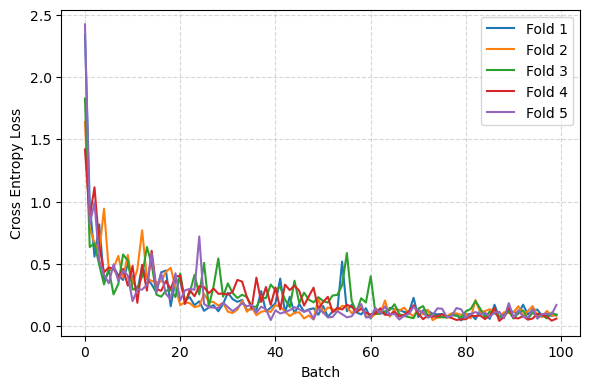

In [22]:
# Plot the batch train losses

plt.figure(figsize=(6, 4))

linestyles = ['-', '--']

for fold_idx in range(n_folds):
    # Extract batch train losses for the current fold and all epochs
    fold_df = fold_results_df[fold_results_df['fold_id'] == fold_idx]
    
    all_batch_train_losses = []
    
    for batch_losses_str in fold_df['batch_train_losses']:
        # Convert the string representation of list of tuples back to list of tuples
        batch_losses = ast.literal_eval(batch_losses_str) if isinstance(batch_losses_str, str) else batch_losses_str
        all_batch_train_losses.extend([loss for _, loss in batch_losses])

    # Plot all batch train losses for this fold
    plt.plot(all_batch_train_losses, label=f'Fold {fold_idx + 1}')
   
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/denver-resnet18_cv_batch_train_loss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

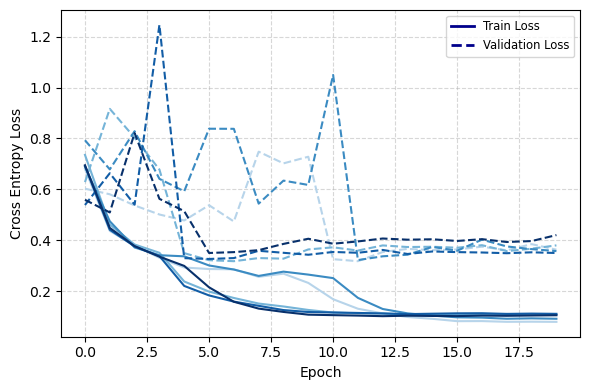

In [23]:
plt.figure(figsize=(6, 4))

# Extract the average validation loss for each fold
fold_avg_val_loss = fold_results_df.groupby('fold_id')['epoch_val_loss'].min().reset_index()
# Sort by the validation loss to determine the order of shading
sorted_folds = fold_avg_val_loss.sort_values(by='epoch_val_loss', ascending=True)['fold_id'].values
# Create a color gradient from light to dark blue
colors = plt.cm.Blues(np.linspace(0.3, 1, len(sorted_folds)))  # Adjust the range for a clearer gradient

# Plot train and validation loss for each fold in the order of sorted validation loss
for idx, fold_idx in enumerate(sorted_folds):
    # Extract the data for the current fold
    fold_data = fold_results_df[fold_results_df['fold_id'] == fold_idx]
    epoch_train_losses = fold_data['epoch_train_loss'].values
    epoch_val_losses = fold_data['epoch_val_loss'].values

    # Plot train/val loss with the corresponding color
    plt.plot(epoch_train_losses, color=colors[idx], linestyle='-')
    plt.plot(epoch_val_losses, color=colors[idx], linestyle='--')

# Add legend for only train and validation loss
dark_blue = '#00008B'  # Hex code for dark blue
train_line = plt.Line2D([0], [0], color=dark_blue, lw=2, linestyle='-')
val_line = plt.Line2D([0], [0], color=dark_blue, lw=2, linestyle='--')
plt.legend([train_line, val_line], ['Train Loss', 'Validation Loss'], loc='upper right', fontsize='small')

plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot
out_png = os.path.join(results_dir, 'figures/denver-resnet18_cv_epoch_trainval_loss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

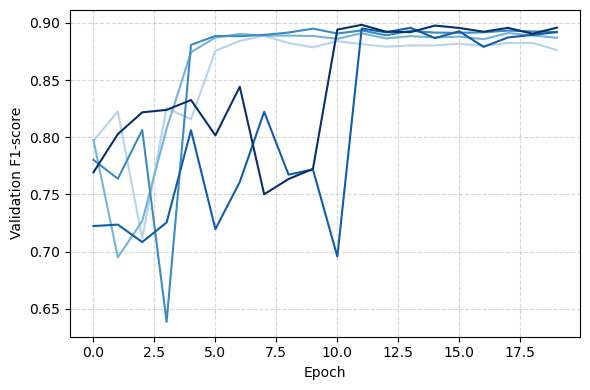

In [24]:
# Same plot but for F1-score
plt.figure(figsize=(6, 4))

# Extract the average validation loss for each fold
fold_avg_f1 = fold_results_df.groupby('fold_id')['val_f1'].max().reset_index()
# Sort by the validation loss to determine the order of shading
sorted_folds = fold_avg_f1.sort_values(by='val_f1', ascending=True)['fold_id'].values
colors = plt.cm.Blues(np.linspace(0.3, 1, len(sorted_folds)))  # Adjust the range for a clearer gradient

# Plot train and validation loss for each fold in the order of sorted validation loss
for idx, fold_idx in enumerate(sorted_folds):
    # Extract the data for the current fold
    fold_data = fold_results_df[fold_results_df['fold_id'] == fold_idx]
    epoch_f1 = fold_data['val_f1'].values
    
    # Plot train/val loss with the corresponding color
    plt.plot(epoch_f1, color=colors[idx], linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Validation F1-score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot
out_png = os.path.join(results_dir, 'figures/denver-resnet18_cv_epoch_valF1score.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [25]:
# Perform predictions on the holdout data for each model

In [26]:
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Holdout set class distribution:
 class_code  code
CS          6       17313
WS          1        2129
AP          3        1624
TL          0         569
CN          2         552
TG          5          46
SL          4          46
Name: count, dtype: int64


In [27]:
# Create dictionaries for mapping
code_mapping = dict(zip(holdout_df['code'].cat.codes, holdout_df['class_code']))  # Mapping to original 'class_code'
desc_mapping = dict(zip(holdout_df['code'], holdout_df['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

AttributeError: Can only use .cat accessor with a 'category' dtype

In [ ]:
# Load the holdout data
holdout_ds = RoofImageDatasetPlanet(holdout_df[['geometry', 'code']], img_path=stack_da_fp, n_bands=n_bands, img_dim=params['window_size'])
holdout_loader = DataLoader(holdout_ds, batch_size=params['batch_size'] * 2, num_workers=2, shuffle=False, pin_memory=True)
print("Holdout data loaded !")

In [ ]:
# Initialize list to store the results:
all_preds = []
# loop the trained models and make predictions
for fold_idx in range(1, n_folds + 1):
    print(f"Making predictions with model from fold {fold_idx}")

    # Load the trained model for the current fold
    model_fp = os.path.join(results_dir, f'denver-resnet18_fold{fold_idx}.pth')
    print(f"Loading model from path: {model_fp}")
    checkpoint = torch.load(model_fp, map_location=device)

    # Initialize the model architecture
    model, _, _, _ = initialize_resnet_model(
        n_classes=n_classes,
        n_bands=n_bands,
        device=device,
        learning_rate=params['learning_rate'],
        momentum=params['momentum'],
        weight_decay=params['weight_decay'],
        patience=params['patience']
    )

    # Load the trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    
    true_codes = []
    pred_codes = []

    # Make predictions on the holdout data
    with torch.no_grad():
        for idx, sample in enumerate(holdout_loader):
            image, label = sample['image'].to(device), sample['code'].to(device)

            # Get the model's predictions
            output = model(image.float())
            predictions = output.argmax(dim=1).cpu().numpy()

            # Store true labels and predictions
            true_codes.extend(label.cpu().numpy())
            pred_codes.extend(predictions)

            if idx % 10 == 0:
                print(f"\tProcessed {idx * params['batch_size']} samples")

    # Map true and predicted labels to their class codes
    true_class_codes = [code_mapping[code] for code in true_codes]
    pred_class_codes = [code_mapping[pred] for pred in pred_codes]

    fold_df = pd.DataFrame({
        'fold_idx': fold_idx,         
        'true_code': true_codes,
        'pred_code': pred_codes,
        'true_label': true_class_codes,
        'pred_label': pred_class_codes
    })

    all_preds.append(fold_df)

    del model
    torch.cuda.empty_cache()
    gc.collect()

# concatenate across folds
preds_df = pd.concat(all_preds, ignore_index=True)

# Save the predictions for later analysis
preds_df.to_csv(os.path.join(results_dir, 'denver-resnet18_cv_holdout_preds.csv'), index=False)
print("Completed predictions for all folds!")

In [ ]:
# Plot the number of correct predictions by class/fold

In [ ]:
preds_df.dtypes

In [ ]:
preds_df.head()

In [ ]:
# Create a DataFrame for plotting correct predictions by class code across folds
preds_df['correct'] = preds_df['true_label'] == preds_df['pred_label']
preds_df_correct = preds_df.groupby(['fold_idx', 'true_label']).agg(correct_count=('correct', 'sum')).reset_index()
preds_df_correct = preds_df_correct.groupby('true_label')['correct_count'].agg(['mean', 'std']).reset_index()

# Get total counts of true labels
total_counts = preds_df.groupby(['fold_idx', 'true_label']).size().reset_index(name='total_count')
total_counts_mn = total_counts.groupby('true_label')['total_count'].mean().reset_index()

# Merge back to data frame
preds_df_correct = preds_df_correct.merge(total_counts_mn, on='true_label', how='left')

plt.figure(figsize=(5, 3))

plt.bar(preds_df_correct['true_label'], preds_df_correct['total_count'], color='lightblue', label='Total Samples')
plt.bar(preds_df_correct['true_label'], preds_df_correct['mean'], yerr=preds_df_correct['std'], 
        capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Class Code')
plt.ylabel('Correct')
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/denver-resnet18_cv_correct_preds.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Generate the classification report

In [ ]:
all_reports = [] # to store the classification reports for each fold
class_codes = list(preds_df['true_label'].unique())
print(class_codes)

# Iterate over the folds
for fold_idx in preds_df['fold_idx'].unique():
    print(f"Create CR for fold [{fold_idx}]")

    fold_preds_df = preds_df[preds_df['fold_idx'] == fold_idx]

    print(fold_preds_df.correct.value_counts())
    
    # Gather the true and predicted labels
    true_labs_fold = fold_preds_df['true_label']
    pred_labs_fold = fold_preds_df['pred_label']

    # Generate the classification report
    cr_fold = pd.DataFrame(classification_report(true_labs_fold, pred_labs_fold, output_dict=True)).transpose()
    cr_fold['fold_idx'] = fold_idx
    cr_fold = cr_fold.reset_index().rename(columns={'index': 'class_code'})
    cr_fold = cr_fold[cr_fold['class_code'].isin(class_codes)] # keep only the per class metrics (i.e., not the weighted average)
    all_reports.append(cr_fold)

# Combine the reports
cr_df = pd.concat(all_reports, axis=0)

# Save the report as a CSV
cr_df.to_csv(os.path.join(results_dir, 'denver-resnet18_cv_classification_reports.csv'))
print(cr_df)

In [ ]:
# Calculate the mean metrics across all folds
cr_summary = cr_df[['class_code', 'precision', 'recall', 'f1-score']].groupby('class_code').agg(['mean', 'std']).reset_index()
cr_summary.columns = ['class_code', 'precision', 'precision_sd', 
                      'recall', 'recall_sd', 
                      'f1-score', 'f1-score_sd']
cr_summary

In [ ]:
cr_summary = cr_summary.sort_values(by='f1-score', ascending=False)

plt.figure(figsize=(5, 3))
plt.bar(cr_summary['class_code'], cr_summary['f1-score'], 
        yerr=cr_summary['f1-score_sd'], capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Class Code')
plt.ylabel('F1-Score')
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/denver-resnet18_cv_mean_f1-score_bar.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Find the best model from the folds

In [ ]:
f1_scores_wt = [] # to store the weighted f1-scores
for fold_idx in cr_df['fold_idx'].unique():
    # Filter data for the current fold
    fold_data = cr_df[cr_df['fold_idx'] == fold_idx]
    
    # Calculate the weighted F1-score for this fold
    total_support = fold_data['support'].sum()
    weighted_f1 = (fold_data['f1-score'] * fold_data['support']).sum() / total_support
    
    # Append the results
    f1_scores_wt.append({'fold_idx': fold_idx, 'weighted_f1_score': weighted_f1})

# Convert to a DataFrame
f1_scores_wt_df = pd.DataFrame(f1_scores_wt)

# Step 2: Identify the best-performing fold
best_fold = f1_scores_wt_df.loc[f1_scores_wt_df['weighted_f1_score'].idxmax()]
print(f"Best performing fold is Fold {int(best_fold['fold_idx'])} with a weighted F1-score of {best_fold['weighted_f1_score']:.4f}")

In [ ]:
# Generate confusion matrices

In [ ]:
class_names = list(code_mapping.values())
print(class_names)

In [ ]:
# For the best performing model (Fold 2)
best_fold_df = preds_df[preds_df['fold_idx'] == int(best_fold['fold_idx'])]
cm_best = confusion_matrix(
    best_fold_df['true_label'], 
    best_fold_df['pred_label'], 
    labels=class_names)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=class_names)
disp.plot(cmap='viridis')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/denver-resnet18_confusion_matrix_bestFold.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()

In [ ]:
# Average across folds

In [ ]:
average_cm = np.zeros((len(class_names), len(class_names)))

# Iterate through each fold and accumulate the confusion matrix
for fold_idx in preds_df['fold_idx'].unique():
    fold_preds = preds_df[preds_df['fold_idx'] == fold_idx]
    cm_fold = confusion_matrix(
        fold_preds['true_label'], 
        fold_preds['pred_label'], 
        labels=class_names
    )
    average_cm += cm_fold

# Divide by the number of folds to get the average
average_cm /= len(preds_df['fold_idx'].unique())
average_cm = np.rint(average_cm).astype(int)

# Plot the confusion matrix
disp_avg = ConfusionMatrixDisplay(confusion_matrix=average_cm, display_labels=class_names)
disp_avg.plot(cmap='viridis', values_format='d')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/denver-resnet18_confusion_matrix_average.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()